# Introduction aux modèles linéaires de Machine Learning avec Python

## Objectif
Ce notebook vise à illustrer certains aspects de la construction des modèles linéaires avec et sans `scikit-learn`. Le but est double, à la fois illustrer l'utilisation de `scipy` et `sklearn` pour fitter des modules linéaires ainsi que d'apprendre à utiliser `plotly` un module de tracé interactif bien adapté aux notebooks.

## Un exemple sans `scikit-learn`

On va traiter un problème jouet extrêmement simple, on va chercher à modéliser la relation entre $X$ et $Y$ avec

$$ Y = 2 \times X + 1 $$

Pour compliquer un peu, on va ajouter un bruit gaussien aux données de sortie (dans un premier temps)

On commence par charger les modules nécessaires

In [1]:
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

`plotly` permet de tracer des graphiques interactifs, depuis quelque temps, on peut en profiter dans les notebook Jupyter

In [2]:
from plotly.graph_objs import Scatter, Figure, Layout

In [3]:
init_notebook_mode(connected=True)
import numpy as np
X = np.random.random(10)


Y = 2*X+1+0.2*np.random.randn(10)

La commande 
python
```
init_notebook_mode(connected=True)
```
sert à initialiser le mode interctif notebook afin de permettre des tracés interactifs.

Pour utiliser correctement le module `plotly` on a aussi besoin d'initaliser chacune des cellules où l'on va faire un tracé plotly avec la fonction Python suivante `configure_plotly_browser_state()`

In [5]:
#for google colab
def configure_plotly_browser_state():
  import IPython
  display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              plotly: 'https://cdn.plot.ly/plotly-latest.min.js?noext',
            },
          });
        </script>
        '''))

In [6]:
configure_plotly_browser_state()


trace = Scatter(
    x=X,
    y=Y,
    mode='markers',
    marker=dict(size=13),
    name="Sample Data",
)

fig = dict(data=[trace], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

Maintenant nous créons la matrice des observations 

In [8]:
M = np.ones([len(X),2])
M[:,1] = X

In [9]:
M

array([[1.        , 0.34048531],
       [1.        , 0.64933279],
       [1.        , 0.99750902],
       [1.        , 0.43293397],
       [1.        , 0.78622551],
       [1.        , 0.03005442],
       [1.        , 0.40942124],
       [1.        , 0.39970084],
       [1.        , 0.02470919],
       [1.        , 0.75398177]])

et nous résolvons le problème aux moindres carrés

$$ min_{\alpha, \beta} ||MA-Y||_2^2$$

où $A = [\alpha,\beta]$

In [10]:
a, b = np.linalg.lstsq(M,Y)[0]

D:\bartoli\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



In [11]:
a

1.0606910325390195

In [12]:
b

1.8957794346778578

*Note* : On utilise ici la méthode `lstsq` de `numpy` qui est précisément faite pour les problèmes aux moindres carrés. Il s'agit d'une méthode `python` qui appelle en réalité des routines numériques stables et éprouvées (ici la SVD de la matrice `M`) de la librairie LAPACK (en C ou Fortran).

On trace maintenant la solution.

In [13]:
configure_plotly_browser_state()
x_gr = np.linspace(0,1,3)
y_gr = b*x_gr+a
trace = Scatter(
    x=X,
    y=Y,
    mode='markers',
    marker=dict(size=13),
    name="Sample Data",
)
trace2 = Scatter(
    x=x_gr,
    y=y_gr,
    mode='lines',
    line=dict(width=4),
    name="Ordinary Least Squares"
)
fig = dict(data=[trace,trace2], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

## Le même exemple avec `scikit-learn`

In [14]:
import sklearn.linear_model as lm
linreg = lm.LinearRegression()

In [15]:
listmethodinit = [method for method in dir(linreg) if not method.startswith('_')]
listmethodinit

['copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'n_jobs',
 'normalize',
 'predict',
 'score',
 'set_params']

In [16]:
linreg.fit(X.reshape(-1, 1), Y.reshape(-1, 1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

*Note* : `scikit-learn` tire parti du côté objet du langage Python pour le développement mais aussi pour l'*utilisation*. Ainsi, en `scikit-learn` l'utilisateur sera souvent appelé à créer des instances des classes de `scikit-learn`, par exemple ici
```python
linreg = lm.LinearRegression()
```
crée une instance de la classe `LinearRegression` qui comprend à son initialisation des méthodes (par exemple `fit` pour entraîner un modèle linéaire).

In [17]:
listmethodafterfit = [method for method in dir(linreg) if not method.startswith('_')]
listmethodafterfit

['coef_',
 'copy_X',
 'fit',
 'fit_intercept',
 'get_params',
 'intercept_',
 'n_jobs',
 'normalize',
 'predict',
 'rank_',
 'score',
 'set_params',
 'singular_']

On constate que notre objet `linreg` comporte désormais des nouveaux attributs

In [18]:
set(listmethodafterfit)-set(listmethodinit)

{'coef_', 'intercept_', 'rank_', 'singular_'}

In [19]:
[linreg.coef_[0][0] , linreg.intercept_[0] ]

[1.8957794346778585, 1.0606910325390202]

On constate que ce sont exactement les mêmes valeurs qu'avec la méthode `lstsq` du module `scipy`. Ce n'est pas surprenant, si on regarde le code `python` de la méthode `.fit` de la classe `LinearRegression` on trouve
```python
self.coef_, self._residues, self.rank_, self.singular_ = \
    linalg.lstsq(X, y)
```

Autrement dit, la méthode `.fit` ne fait ni plus ni moins que de fournir une interface simplifiée à la méthode  `lstsq`. Si par exemple, on souhaite changer la méthode LAPACK appelée, on ne pourra pas le faire depuis `scikit-learn`.

## Exercices regression ridge et lasso

**Exercice 1** : On va chercher à modéliser des données de la forme 
$ Y = -2 X^2 + X - 1 $ en suivant les mêmes étapes que précédemment
* Générer un échantillon de 50 points avec un bruit gaussien
* Tracer cet échantillon avec plotly
* Estimer la régression linéaire avec scipy et ensuite avec sklearn
* Tracer les régressions obtenues

**Exercice 2** : Ridge regression. On reprend l'exemple précédent mais on va cette fois utiliser la ridge regression
* Calculer directement les coefficients de Ridge Regression en fonction de $\lambda$ (Utiliser la formule vue en cours)
* Tracer l'évolution des coefficients en fonction de $\lambda$ typiquement pour $\lambda$ allant de $0$ à $10^6$

**Exercice 3** : Lasso Regression 
* Reprendre l'example précédant avec la régression lasso.
* Chercher dans la documentation de sklearn comment créer un estimateur lasso
* Trouver la meilleure valeur de $\lambda$ par validation croisée

## Exemple de calcul des leviers avec `statsmodels`

Le package `stasmodels` implémente de très nombreuses fonctionnalités et tests statistiques autour de la régression linéaire. Comme le package `scikit-learn` ne permet d'obtenir le calcul des leviers rapidement et ne sort pas non plus nativement beaucoup de statistiques sur le résultat de la régression, on montre ici comment utiliser `statsmodels`

In [20]:
import pandas as pd
import itertools
from itertools import chain, combinations
import statsmodels.formula.api as smf
import scipy.stats as scipystats
import statsmodels.api as sm
import statsmodels.stats.stattools as stools
import statsmodels.stats as stats 

Pour calculer une régression linéaire avec `statsmodels`, on procède de la manière suivante

In [22]:
lm = sm.OLS(Y, sm.add_constant(X)).fit()

L'objet `lm` contient énormément de résultats de tests statistiques 

In [23]:
print(lm.summary()) 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     78.84
Date:                Thu, 25 Jun 2020   Prob (F-statistic):           2.05e-05
Time:                        15:27:56   Log-Likelihood:                 2.8492
No. Observations:                  10   AIC:                            -1.698
Df Residuals:                       8   BIC:                            -1.093
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0607      0.121      8.734      0.0

D:\bartoli\Anaconda3\lib\site-packages\scipy\stats\stats.py:1394: UserWarning:

kurtosistest only valid for n>=20 ... continuing anyway, n=10



On constate qu'on obtient bien les mêmes résultats qu'avec les précédentes méthodes pour les coefficients de la régression linéaire.

On peut obtenir directement les valeurs des leviers pour les points de la base de la manière suivante 

In [24]:
influence = lm.get_influence()
leverage = influence.hat_matrix_diag

In [25]:
leverage

array([0.12218852, 0.13067299, 0.39214306, 0.10269831, 0.20162585,
       0.3253542 , 0.10587045, 0.10753756, 0.33071113, 0.18119793])

On peut désormais déterminer les points d'influence importante en comparant les valeurs des leviers à $$\frac{\mbox{trace}(H)}{N}$$

In [26]:
trace = sum(leverage)

In [27]:
leverage > trace/len(leverage)

array([False, False,  True, False,  True,  True, False, False,  True,
       False])

On constate donc que les points $1$, $4$, $5$ et $8$ ont des influences importantes (cela changera probablement en rejouant le notebook). Comme dit en formation, la valeur du point et l'erreur faite par la régression ont aussi leur importance, `statsmodels` propose donc directement d'évaluer les leviers vis-à-vis du résidu et de tracer un graphe d'influence.

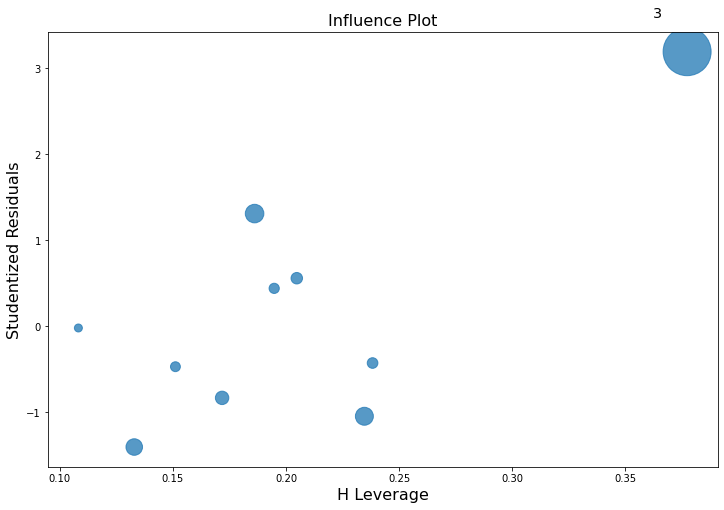

In [34]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,8))
fig = sm.graphics.influence_plot(lm, alpha  = 0.05, ax = ax, criterion="cooks")

## Exemple de calcul de Total Least Squares

On termine ce notebook en décrivant une approche pour réaliser une régression par Moindres Carrés Totaux telle que présentée dans la formation. Les parties de code suivantes sont librement inspirées de [cet article](https://towardsdatascience.com/total-least-squares-in-comparison-with-ols-and-odr-f050ffc1a86a)

Supposant maintenant que nous introduisons une erreur de mesure sur les entrées.

$$ Y = 2 \times (X+\varepsilon_1) + 1 + \varepsilon_2$$

avec $\varepsilon_1$ l'erreur de mesure sur les entrées. On diminue l'erreur sur la sortie pour se mettre dans un cas où la source d'erreur est principalement sur les entrées.


In [28]:
import numpy as np
X_init = np.random.random(50)
eps1 = 0.1*np.random.randn(50)
eps2 = 0.01*np.random.randn(50)
Y_true = 2*X_init+1
X_real = X_init+eps1
Y_real = 2*X_real+1+eps2


In [29]:
configure_plotly_browser_state()
trace = Scatter(
    x=X_init,
    y=Y_real,
    mode='markers',
    marker=dict(size=13),
    name="Observed Data",
)
trace2 = Scatter(
    x=X_real,
    y=Y_real,
    mode='markers',
    marker=dict(size=13),
    name="Real Data (non observable)",
)
x_gr = np.linspace(0,1)
y_gr = 2*x_gr+1
trace3 = Scatter(
    x=x_gr,
    y=y_gr,
    mode='lines',
    line=dict(width=4),
    name="Real Model"
)
fig = dict(data=[trace,trace2,trace3], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

On utilise la fonction de l'article cité plus haut

In [30]:
import numpy.linalg as la
def tls(X,y):
    
    if X.ndim is 1: 
        n = 1 # the number of variable of X
        X = X.reshape(len(X),1)
    else:
        n = np.array(X).shape[1] 
    
    Z = np.vstack((X.T,y)).T
    U, s, Vt = la.svd(Z, full_matrices=True)
    
    V = Vt.T
    Vxy = V[:n,n:]
    Vyy = V[n:,n:]
    a_tls = - Vxy  / Vyy # total least squares soln
    
    Xtyt = - Z.dot(V[:,n:]).dot(V[:,n:].T)
    Xt = Xtyt[:,:n] # X error
    y_tls = (X+Xt).dot(a_tls)
    fro_norm = la.norm(Xtyt, 'fro')
    
    return y_tls, X+Xt, a_tls, fro_norm

In [31]:
M_init = np.ones([len(X_init),2])
M_init[:,1] = X_init
y_tls,X_tls,coeff_tls,fro_norm = tls(M_init, Y_real)

Les coefficients de la régression par moindres carrés totaux sont dans la variables `coeff_tls`

In [32]:
a_tls, b_tls = coeff_tls[1], coeff_tls[0]
print(f"a: {a_tls}, b: {b_tls}")

a: [2.19273347], b: [0.89926003]


On peut maintenance comparer la régression avec la régression classique

In [33]:
b_ols, a_ols = np.linalg.lstsq(M_init,Y_real)[0]
print(f"a: {a_ols}, b: {b_ols}")

a: 2.089576508789233, b: 0.9464091807327891


D:\bartoli\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



In [34]:
configure_plotly_browser_state()
trace = Scatter(
    x=X_init,
    y=Y_real,
    mode='markers',
    marker=dict(size=13),
    name="Observed Data",
)
trace2 = Scatter(
    x=X_real,
    y=Y_real,
    mode='markers',
    marker=dict(size=13),
    name="Real Data (non observable)",
)
x_gr = np.linspace(0,1)
y_gr = 2*x_gr+1
trace3 = Scatter(
    x=x_gr,
    y=y_gr,
    mode='lines',
    line=dict(width=4),
    name="Real Model"
)
y_tls = a_tls*x_gr+b_tls
trace4 = Scatter(
    x=x_gr,
    y=y_tls,
    mode='lines',
    line=dict(width=4),
    name="TLS regression"
)
y_ols = a_ols*x_gr+b_ols
trace5 = Scatter(
    x=x_gr,
    y=y_ols,
    mode='lines',
    line=dict(width=4),
    name="OLS regression"
)
fig = dict(data=[trace,trace2,trace3,trace4,trace5], layout={})
fig['layout']['xaxis'] = dict(title='Variable X')
fig['layout']['yaxis'] = dict(title='Variable Y')

iplot(fig)

On observe que la régression par Moindres Carrés Totaux est plus proche du vrai modèle (non observable).